# Install ML dependencies

Install `mxnet` and `gluonts` with pip. For example, with conda, after activating your environment:
```shell
> conda activate my-environment
> pip install mxnet
# https://www.anaconda.com/blog/using-pip-in-a-conda-environment
> pip install gluonts
```

# Load ingredients, contents, price data

In [1]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.trainer import Trainer
from gluonts.dataset.util import to_pandas

In [3]:
# laoading the sales datframe and adding a column for the predictions

sales_df = pd.read_csv("sales.csv")

sales_df['predicted_sales']  = np.nan

# convert date column to date
sales_df['date'] = pd.to_datetime(sales_df['date'])

# atoti cube creation

In [4]:
import atoti as tt

Thanks for using atoti 0.4.3!

To keep using it, update to atoti's latest version or upgrade to Atoti+ in the coming 5 days.


Welcome to atoti 0.4.3!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


In [5]:
# creating a session - it spins up an in-memory database - similar to Apache Spark - ready to slice’n’dice your big data set.
# In addition to that, it launches a dashboarding Tableau-like web-app
from atoti.config import create_config

config = create_config(metadata_db="./metadata.db", java_args=["-Dlogging.level.com.qfs.msg.csv=DEBUG"])
session = tt.create_session(config=config)

In [6]:
# loading salad content
salad_content = session.read_csv(
    "salad_content.csv",
    keys=["prod_id", "ing_id" ],
    store_name="SaladContents",
)
salad_content.head()

product_name  quantity
prod_id       ing_id                               
561_GCS_salad 53534   Greek Chicken Salad      12.5
              34534   Greek Chicken Salad       0.0
              976     Greek Chicken Salad      57.5
              845     Greek Chicken Salad      20.0
              56764   Greek Chicken Salad      10.0

In [7]:
# loading prices datasets

selling_price_df = pd.read_csv("selling_price.csv")
selling_price = session.read_pandas(
    selling_price_df.drop('product_name', axis = 1),
    keys=["prod_id" ],
    store_name="Prices",
)
selling_price.head()

,production_cost,selling_price
prod_id,,
561_GCS_salad,2.1,6.50
558_CS_salad,1.5,5.75
761_TCS_salad,1.9,6.25
641_CCS_salad,2.3,7.40
583_GVS_salad,1.5,5.50


In [8]:
# loading ingredients datasets

ingredients_df = pd.read_csv("ingredients.csv")
ingredients = session.read_pandas(
    ingredients_df,
    keys=["ing_id"],
    store_name="Ingredients",
)
ingredients.head()

,ingredient,shelf_life,cost
ing_id,,,
53534,lettuce,2,4.6
34534,parmesan,30,16.0
976,feta,21,14.0
845,pasta,1,7.0
56764,sweet_corn,90,9.0


In [9]:
# loading sales datasets

sales = session.read_pandas(
    sales_df.drop('product_name',  axis = 1),
    keys=["prod_id","date"],
    store_name="Sales",
    types={'predicted_sales': tt.types.INT_PYTHON_LIST, 'sold_units' : tt.types.DOUBLE_NULLABLE}
)
sales.head()

sold_units  predicted_sales
prod_id       date                                   
561_GCS_salad 2019-01-01        80.0              NaN
              2019-01-02       105.0              NaN
              2019-01-03       101.0              NaN
              2019-01-04       122.0              NaN
              2019-01-05        75.0              NaN

In [10]:
sales

Store(_name='Sales', _scenario='Base', _columns={'prod_id': Column(name='prod_id', data_type=AtotiType(java_type='string', nullable=True)), 'date': Column(name='date', data_type=AtotiType(java_type='LocalDate[yyyy-MM-dd]', nullable=True)), 'sold_units': Column(name='sold_units', data_type=AtotiType(java_type='double', nullable=True)), 'predicted_sales': Column(name='predicted_sales', data_type=AtotiType(java_type='atoti_list_int[][,]', nullable=True))})

In [11]:
sales.shape

{'rows': 1824, 'columns': 4}

In [12]:
salad_content.join(
    selling_price, mapping={"prod_id": "prod_id"}
)

In [13]:
salad_content.join(ingredients, mapping={"ing_id": "ing_id"})

In [14]:
salad_content.join(sales, mapping={"prod_id": "prod_id"})

In [15]:
#Now we create the cube
salad_cube = session.create_cube(salad_content, "SaladCube")

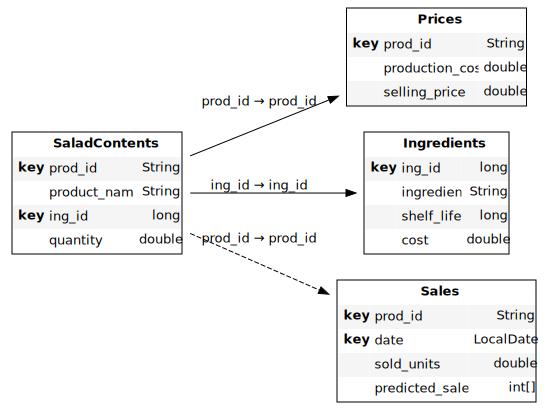

In [16]:
salad_cube.schema

# load the sales time series and do the sales predictions

## predictions for the time series

### Getting the quantiles for each of the five products

In [17]:
#load dataframe from csv
df = pd.read_csv("sales_raw.csv")

In [18]:
df.head()

,date,greek_chicken_salad,caesar_salad,turkish_chickpea_salad,cheese_chicken_salad,grilled_veggies_salad,chicken_pesto_pasta_salad
0,1/1/2019,80,30,65,32,101,13
1,1/2/2019,105,47,97,53,148,98
2,1/3/2019,101,51,86,53,124,39
3,1/4/2019,122,66,113,71,161,103
4,1/5/2019,75,25,59,27,95,6


In [19]:
mx.random.seed(36)
np.random.seed(36)

for column in df.columns[1:]:
    
    training_data = ListDataset(
    [{"start": df.date[0], "target": df[column]}],
    freq = "D")
    
    estimator = DeepAREstimator(freq="D", prediction_length=60, trainer=Trainer(epochs=1))
    predictor = estimator.train(training_data=training_data)
    
    test_data = ListDataset(
    [{"start": df.date[0], "target": df[column]}],
    freq = "D")
    
    for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
        pass
    
    globals()['sales_'+str(df[column].name)] = []
    print(df[column].name)
    
    for i in np.linspace(0,0.99, 10):
        globals()['sales_'+str(df[column].name)].append(forecast.quantile(i)) 

        
    globals()['sales_'+str(df[column].name)] = np.reshape(globals()['sales_'+str(df[column].name)], (10, 60)).T
    
    
    globals()['sales_'+str(df[column].name)] = globals()['sales_'+str(df[column].name)].tolist()
    
    print(type(globals()['sales_'+str(df[column].name)]))

    
    for i, item in enumerate(globals()['sales_'+str(df[column].name)]):

        new = [int(round(j)) for j in item]
        new2 = [i if i > 0 else 0 for i in new]
        (globals()['sales_'+str(df[column].name)])[i] = new2

#     print((globals()['sales_'+str(df[column].name)]))

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

greek_chicken_salad
<class 'list'>
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

caesar_salad
<class 'list'>
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

turkish_chickpea_salad
<class 'list'>
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

cheese_chicken_salad
<class 'list'>
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

grilled_veggies_salad
<class 'list'>
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:06<00:00,  7.45it/s, epoch=1/1, avg_epoch_loss=5.1]


chicken_pesto_pasta_salad
<class 'list'>


In [20]:
# create a new dataframe to be appended

col_names =  list(sales_df.columns) 
df_to_append  = pd.DataFrame(columns = col_names)

In [21]:
df_to_append = df_to_append.drop('product_name',  axis = 1)

In [22]:
# defining the range of dates and the list of products 
list_products = ['561_GCS_salad', '558_CS_salad', '761_TCS_salad', '641_CCS_salad', '583_GVS_salad', '572_CPS_salad']
list_date = pd.date_range(start=df.loc[df.index[-1], "date"], periods = 61, freq='D', closed = 'right')

In [23]:
# loading the dates and changing the format to dattime to be double sure
df_to_append['date'] = list_date
df_to_append['date'] = pd.to_datetime(df_to_append['date'])

# replicate the dates for each product
df_to_append = pd.concat([df_to_append]*len(list_products), ignore_index=True)

In [24]:
# defing the list of product ids to fit in the dataframe
product_id = []
for prod in list_products:
    product_append = np.repeat(prod, len(list_date))
    product_id.append(product_append)

#creating the main list from the list of lists
list_product_id = []
for x in product_id:
    for y in x:
        list_product_id.append(y)

In [25]:
# concattinating the list of various predictions for each product 
predicted_sales = sales_greek_chicken_salad + sales_caesar_salad + sales_turkish_chickpea_salad + sales_cheese_chicken_salad + sales_grilled_veggies_salad + sales_chicken_pesto_pasta_salad

In [26]:
# appending values in the dataframe

df_to_append['prod_id'] = list_product_id
df_to_append['sold_units'] = np.nan
df_to_append['predicted_sales'] = predicted_sales

In [27]:
df_to_append.head()

,prod_id,date,sold_units,predicted_sales
0,561_GCS_salad,2019-11-01,NaN,"[59, 90, 95, 97, 101, 103, 106, 111, 116, 149]"
1,561_GCS_salad,2019-11-02,NaN,"[0, 84, 92, 94, 98, 102, 106, 109, 113, 146]"
2,561_GCS_salad,2019-11-03,NaN,"[20, 82, 86, 92, 95, 97, 100, 106, 111, 143]"
3,561_GCS_salad,2019-11-04,NaN,"[0, 79, 87, 91, 96, 98, 101, 106, 112, 140]"
4,561_GCS_salad,2019-11-05,NaN,"[0, 84, 90, 97, 100, 103, 107, 110, 115, 129]"


# appending this df to the sales store in atoti

In [38]:
sales.load_pandas(df_to_append)

In [49]:
m=salad_cube.measures
lvl=salad_cube.levels

m["sales.SUM"]=tt.agg.sum(sales["sold_units"])
m["predicted_sales.SUM"]=tt.agg.sum(sales["predicted_sales"])
m["quantile"] = 0.50
m["quantile_total_predicted_sales"]=tt.array.quantile(m["predicted_sales.SUM"], m["quantile"])
m["true_sales.SUM"]=tt.agg.sum(tt.where(m["sales.SUM"] == None, m["quantile_total_predicted_sales"], m["sales.SUM"]), scope=tt.scope.origin(lvl["date"]))

In [50]:
salad_cube.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

In [55]:
salad_cube.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [56]:
qtle_simulation = salad_cube.setup_simulation(name='qtle', base_scenario='0.5', replace=[m["quantile"]])

In [67]:
qtle_simulation.scenarios["0.95"] = 0.95
qtle_simulation.scenarios["0.05"] = 0.05

In [68]:
salad_cube.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.